# Introducction to PINN's : First approximation 

Las redes neuronales (NN) tienen una gran capacidad predictiva sobre todo por su capacidad de encontrar relaciones no lineales entre los datos de entrada y salida, pero muchas veces para su aplicación en ciencia su uso carece de interpretabilidad. En esencia las NN actúan como una caja negra, en donde las relaciones que desarrolla en la fase de entrenamiento son difíciles(por no decir imposible)de entender por los humanos.

Una posible solución para el problema anterior es agregar un término extra a la función de error, a este término lo denominaremos "regularización física" y principalmente actúa como una regularización. Como es sabido las regularizaciones sirven para evitar el sobre ajuste y mejorar la capacidad de generalización de la NN. Dos de las regularizaciones más usuales son la Lazzo (L1) y Ridge (L1). Ambas regularizaciones consideran término  𝜆  multiplicado por el término regularizador, para un mismo  𝜆  la regularización L1, para la actualización de los pesos, considera en menor medida los outliers, en otras palabras le da más importancia a los valores que tengan menor varianza. Por otro lado, la regularización L2, de manera contraria a la L1, considera en mayor medida los outliers.

Teniendo en mente la idea de regularización y considerando un contexto donde se tenga datos que represente algún fenómeno físico del cual se tenga conocimiento a priori, es valido preguntarse ¿es posible agregar algún término de penalización que priorice las soluciones físicamente posible, y así ayude a la red a una mejor generalización? Bueno, como es de esperarse esta pregunta ya fue respondida por los autores del paper “Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations” en el cual aplican el enfoque antes explicado y demuestran cuál es el término que ayuda a la red neuronal a respetar las leyes de la física subyacen al fenómeno que se está estudiando.

# A bit of context.

En la investigación antes expuesta se presentan las redes neuronales restringidas físicamente: redes neuronales que son entrenadas para resolver tareas de aprendizaje supervisado respetando cualquier ley física que este dentro de la ecuación diferencial que describe la dinámica del sistema estudiado.

Los autores presentan dos tipos de problemas que se pueden resolver mediante este enfoque.

* Inferir la solución para PDE's.  
* Descubrimiento de PDE's. 

Las redes neuronales resultantes forman una nueva clase de aproximadores de funciones universales eficientes en datos que codifican naturalmente cualquier ley física subyacente como información previa [1]. 

En este documento tomaré como ejemplo el oscilador armónico amortiguado, ya que al tener una solución exacta me posibilitara la comparación de resultados para distintos enfoques. Principalmente, compararé el error y tiempo de cómputo de los siguientes enfoques: 

* Técnicas tradicionales para resolver ecuaciones diferenciales.
* Red neuronal sin restricciones físicas. 
* PINN. 
 
Y finalmente, aplicaré una PINN para encontrar los parámetros de la ecuación diferencial del oscilador armónico amortiguado. 

Ante que todo, debo agradecer a Ben Moseley por su blog: [So, what is a physics-informed neural network?](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)  en donde obtuve la mayor parte de la información para la elaboración de este documento. 

# 1-D Damped harmonic oscillator 

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0,
$$

$$
 \ddot u+ 2\gamma \dot u+\omega_0^2 u = 0
$$

Con C.I :
*  $$u(0)=1~~~,~~~\dot u=0$$

Donde: 

  * $$\gamma=\frac{\mu}{2m}~~~~,~~~~\omega_0^2=\frac{k}{m}\ $$
  

Recordar que: 
* $\omega_0$ => Frecuencia propia de oscilación
* b => Factor de amortiguacion 
* k => Constante del resorte  

Si $γ < ω_0$ tenemos un oscilador sub-amortiguado. 

This has the following exact solution: 

$$u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.$$

More information in blog post: https://beltoforion.de/en/harmonic_oscillator/.

``
conda create -n pinn python=3
conda activate pinn
conda install -r requirements.txt
``

# Generator data 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from Utilities.plotting import mkdir  
from Utilities.plotting import save_gif
from Utilities.plotting import plot_nn_result  
from Utilities.plotting import plot_pinn_result  
from IPython.display import Image

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

First, we generate some training data from a small part of the true analytical solution.\n"

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,2]$.

torch.Size([2000, 1]) torch.Size([2000, 1])


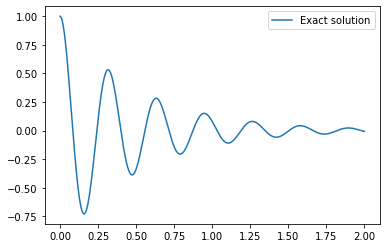

In [3]:
d, w0 = 2, 20

# get the analytical solution over the full domain
N_f = 2000
t = torch.linspace(0,2,N_f).view(-1,1)
u = oscillator(d, w0, t).view(-1,1)
print(t.shape, u.shape)

plt.figure()
plt.plot(t, u, label="Exact solution")
plt.legend()
plt.show()

# Traditional approach to solve differential equation. 


* taylor 
* runge kutta
* multiples pasos 
* ... (compare stability (?))



# apply traditional methods 

* **do this mainly to measure execution times**

* **measure error, interpolation and inference**


# NN aproach to interpolate data 

overffiting 

# Generate train data  

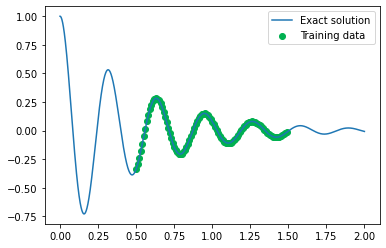

In [4]:
t_data= t[500:1500:10]
u_data= u[500:1500:10]
plt.figure()
plt.plot(t, u, label="Exact solution")
plt.scatter(t_data, u_data, color="#00B050", label="Training data")
plt.legend()
plt.show()

In [5]:
N_train = len(t_data)
idx = np.random.choice(t_data.shape[0], N_train, replace=False)
len(idx)

100

In [6]:
t_train = t_data[idx,:].detach().requires_grad_(True).float().to(device)
u_train = u_data[idx,:].detach().requires_grad_(True).float().to(device)
t_cuda = torch.clone(t).to(device)

In [7]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        self.optimizer_Adam = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.to(device)
        self.iter = 0
        
    def forward(self, t):
        out = self.layers(t)
        return out

In [8]:

torch.manual_seed(123)

layers = [1]+4*[20]+[1]
model = DNN(layers)
files = []

mkdir(name="plots")
mkdir("plots","nn")

Directory 'plots' was already created
Directory 'nn' was already created


In [ ]:
%%time
nIter = 50000
for epoch in range(1,nIter+1):
    
    #zero grad
    model.optimizer_Adam.zero_grad()
    
    # compute the "data loss"
    u_pred = model.forward(t_train)
    
    # use mean squared error (MSE)
    loss = torch.mean((u_pred-u_train)**2)
    
    # backward
    loss.backward()
    
    #step
    model.optimizer_Adam.step()

    # plot the result as training progresses
    if (model.iter) % 150 == 0:

        u_pred = model.forward(t_cuda).detach().cpu().numpy()
        """
        falta importar plot_result_nn 
        """

        plot_nn_result(t,u,t_data,u_data,u_pred,model.iter)

        file = "plots/nn/nn_%.8i.png"%(model.iter)

        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (model.iter) % 6000 == 0: plt.show()
        else: plt.close("all")
    
    #update iteration 
    model.iter += 1
            


In [ ]:
mkdir("plots","nn_gif")

In [ ]:
save_gif("plots/nn_gif/nn.gif", files, fps=20, loop=0)

In [9]:
def display_gif(path):
    with open(path,'rb') as f:
        display(Image(data=f.read(), format='png'))

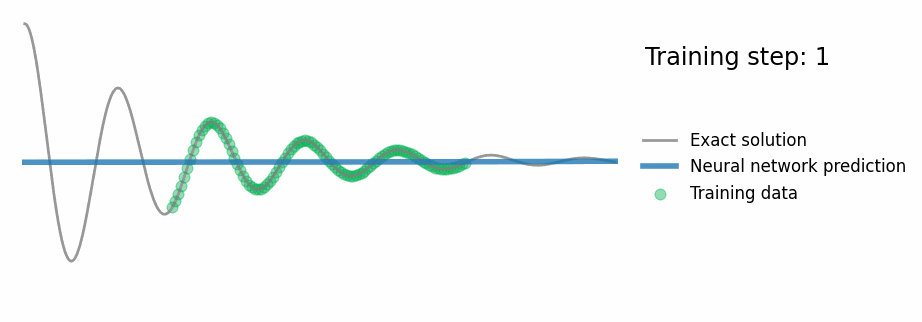

In [10]:
display_gif("plots/nn_gif/nn.gif")

# pequeña descripcion de overfiting 

# PINN approach solve 

- make train and test set 
- define arquitecture 
- define optimizer 

compare error and time with traditional methods.

# PINN approach discovery 

In [ ]:
lambda1_teo, lambda2_teo = 2*d, w0**2

# Define funtion for graph train of neural networks 

# Conclusion 


# Referencias: 

[1] Raissi, M., Perdikaris, P. y Karniadakis, GE (2019). Redes neuronales informadas por la física: un marco de aprendizaje profundo para resolver problemas directos e inversos que involucran ecuaciones diferenciales parciales no lineales . Revista de Física Computacional.

[2] Problema de física inspirado en esta publicación de blog: https://beltoforion.de/en/harmonic_oscillator/


